#### **Preliminaries**

In [15]:
import h5py
import numpy as np
metadata =  h5py.File('/home/shahed/finkerlab_data/HB02.h5')

for key in metadata.keys():
    print (key, metadata[key].shape)

TestNum_cum (1,)
ecog_alldataset (169075, 225)
end_ind_re_valid_alldataset (372,)
formant_re_alldataset (169075, 6)
intensity_re_alldataset (169075,)
label_alldataset (372,)
noisesample_re_alldataset (256,)
pitch_re_alldataset (169075,)
start_ind_re_valid_alldataset (372,)
wave_re_alldataset (21641600, 1)
wave_re_spec_alldataset (169075, 256)
wave_re_spec_amp_alldataset (169075, 256)


In [16]:
ecog = metadata['ecog_alldataset'] 
print(ecog.shape)
print(f'ecog length : {ecog.shape[0]/125}')

speech = metadata['wave_re_alldataset']
print(speech.shape)
print(f'speech length : {speech.shape[0]/16000}')

start_idx = metadata['start_ind_re_valid_alldataset']
end_idx = metadata['end_ind_re_valid_alldataset']
trial_dur = []

for i in range(len(start_idx)):
    start_time = start_idx[i]/125
    end_time = end_idx[i]/125
    trial_dur.append(end_time-start_time)
    # print(f'start idx : {int(start_idx[i]*16000/125)} ({start_idx[i]/125} sec), end idx : {int(end_idx[i]*16000/125)} ({end_idx[i]/125} sec)')

print(f'max trial duration : {max(trial_dur)}')
print(f'min trial duration : {min(trial_dur)}')
print(f'mean trial duration : {np.mean(trial_dur)}')
# print(np.sort(trial_dur))

(169075, 225)
ecog length : 1352.6
(21641600, 1)
speech length : 1352.6
max trial duration : 1.727999999999838
min trial duration : 0.27199999999999136
mean trial duration : 0.5758709677419356


In [17]:
# import os
# import numpy as np
# import soundfile as sf  # pip install soundfile

# fs = 16000                   # your known sampling rate
# T = 190.0                      # chunk length in seconds (change as needed)

# speech = metadata['wave_re_alldataset']
# print(speech.shape)
# print(f'speech length : {speech.shape[0]/16000}')

# # Ensure directory exists
# save_dir = "/home/shahed/finkerlab_data/speech_chunks/"
# os.makedirs(save_dir, exist_ok=True)

# chunk_len = int(T*fs) # speech.shape[0]
# num_samples = speech.shape[0]
# num_chunks =  num_samples // chunk_len

# print(f"Total chunks = {num_chunks}")

# for i in range(num_chunks):
#     start = i * chunk_len
#     end = start + chunk_len
#     chunk = speech[start:end]
#     # Convert to mono if multi-channel (optional)
#     if chunk.ndim > 1:
#         chunk = chunk.mean(axis=-1)
#     # File name
#     outpath = os.path.join(save_dir, f"chunk_{i:04d}.wav")
#     # Save
#     sf.write(outpath, chunk, fs)
# print("Done! Check the 'speech_chunks/' folder.")


#### **KEY DECISION PARAMS**

In [18]:
import torch, random

USE_PCA = 1  

USE_WHISPER = False      
WHISPER_FEAT = 384 # for tiny
WHISPER_VERSION = 'tiny'
USE_LAYERNORM = True 

MODEL = 'cnn'
AUGMENT = True   

NUM_EPOCHS = 100 
DROPOUT = 0.5
BATCH_SIZE = 64

np.random.seed(42)
random.seed(4)
torch.manual_seed(0)

#### **Define spectrogram generator for Whisper**

In [19]:
import librosa, random, torch
import numpy as np
from scipy.signal import resample

def whisper_log_mel_spectrogram_numpy(audio: np.ndarray, 
                                      sample_rate: int = 16000, 
                                      n_mels: int = 80) -> np.ndarray:
    # Convert to mono if multi-channel
    if audio.ndim == 2:
        audio = audio.mean(axis=0)  # average across channels
    elif audio.ndim != 1:
        raise ValueError(f"Audio array must be 1D or 2D, got {audio.ndim}D")

    # Whisper parameters
    n_fft = 400
    hop_length = 160
    win_length = 400
    f_min = 0
    f_max = 8000
    
    # Compute STFT
    stft = librosa.stft(audio, 
                        n_fft=n_fft, 
                        hop_length=hop_length, 
                        win_length=win_length,
                        window='hann',
                        center=True,
                        pad_mode='reflect')
    
    # Compute magnitude spectrogram
    magnitude = np.abs(stft) ** 2  # power spectrogram
    # Create Mel filterbank
    mel_basis = librosa.filters.mel(sr=sample_rate,
                                    n_fft=n_fft,
                                    n_mels=n_mels,
                                    fmin=f_min,
                                    fmax=f_max,
                                    htk=True)  # Use HTK formula like Whisper
    
    # Apply Mel filterbank
    mel = np.dot(mel_basis, magnitude)
    
    # Log compression (base 10 like Whisper)
    log_mel = np.log10(np.clip(mel, a_min=1e-10, a_max=None))
    return log_mel

#### **Generate the data pairs**

In [20]:
# Parameters (same as before)
fs_ecog = 125
fs_speech = 16000
target_fs = 100               # 100 Hz target sampling rate
hop_length = int(0.01 * fs_speech)   # 0.01 sec → 160 samples
win_length = int(0.025 * fs_speech)  # 25 ms window
n_fft = 1024
n_mels = 80 
target_frames = 100           # exactly 1 second at 100 Hz

ecog = metadata['ecog_alldataset']          # shape (N_samples, n_channels)
speech = metadata['wave_re_alldataset']     # shape (N_samples,) or (N_samples, nch)
start_idx = metadata['start_ind_re_valid_alldataset']
end_idx = metadata['end_ind_re_valid_alldataset']

ecog_trials = []
mel_trials = []
durations = []

for i in range(len(start_idx)):
    s_e = start_idx[i]
    e_e = end_idx[i]
    ecog_seg = ecog[s_e:e_e]      # (T_ecog, n_channels)
    start_t = s_e / fs_ecog
    end_t   = e_e / fs_ecog
    s_sp = int(start_t * fs_speech)
    e_sp = int(end_t   * fs_speech)

    speech_seg = np.squeeze(speech[s_sp:e_sp])
    # print(speech_seg.shape)
    # skip tiny segments
    if len(speech_seg) < hop_length:
        continue

    mel = whisper_log_mel_spectrogram_numpy(speech_seg, fs_speech)

    # Resample ECoG to target_fs
    T_target = int(np.round((end_t - start_t) * target_fs))
    if T_target <= 0:
        continue
    # Guard in case ecog_seg is 1D -> make it Nx1
    if ecog_seg.ndim == 1:
        ecog_seg = ecog_seg[:, None]
    ecog_resampled = resample(ecog_seg, T_target, axis=0)  # (T_target, n_channels)

    # ----- Clip or pad MEL to (n_mels, target_frames) -----
    T_mel = mel.shape[1]
    if T_mel >= target_frames:
        mel_fixed = mel[:, :target_frames].astype(np.float32)
    else:
        mel_fixed = np.zeros((n_mels, target_frames), dtype=np.float32)
        mel_fixed[:, :T_mel] = mel

    # ----- Clip or pad ECoG to (target_frames, n_channels) -----
    T_e = ecog_resampled.shape[0]
    n_channels = ecog_resampled.shape[1]
    if T_e >= target_frames:
        ecog_fixed = ecog_resampled[:target_frames, :].astype(np.float32)
    else:
        ecog_fixed = np.zeros((target_frames, n_channels), dtype=np.float32)
        ecog_fixed[:T_e, :] = ecog_resampled

    # Store
    ecog_trials.append(ecog_fixed)        # (target_frames, n_channels)
    mel_trials.append(mel_fixed)          # (n_mels, target_frames)
    durations.append(end_t - start_t)

# Convert to arrays
ecog_trials = np.stack(ecog_trials, axis=0)   # (num_trials, target_frames, n_channels)
mel_trials = np.stack(mel_trials, axis=0)     # (num_trials, n_mels, target_frames)
durations = np.array(durations)

print("ECoG trials :", ecog_trials.shape)
print("MEL trials  :", mel_trials.shape)

ECoG trials : (372, 100, 225)
MEL trials  : (372, 80, 100)


#### **Dataset class**

In [21]:
import torch
from torch.utils.data import Dataset 
import torch.nn as nn
import random
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

class ECoGDataset(Dataset): 
    def __init__(self, mel, ecog, augment=True):
        self.mel = torch.tensor(mel, dtype=torch.float32)     # (N, 80, 100)
        self.ecog = torch.tensor(ecog, dtype=torch.float32)   # (N, 100, 225)
        self.augment = augment
    def __len__(self):
        return self.mel.shape[0]
    def __getitem__(self, idx):
        mel = self.mel[idx]      # (80, 100)
        ecog = self.ecog[idx]    # (100, 225)
        if self.augment:
            if random.random() < 0.5:
                mel = mel + 0.316 * torch.randn_like(mel)
            if random.random() < 0.01:
                T = mel.shape[1]    # number of frames (100)
                mask_width = random.randint(1, 5)
                t0 = random.randint(0, T - mask_width)
                mel[:, t0:t0 + mask_width] = 0.0
        return mel, ecog

mel_data = mel_trials           # (372, 80, 100)
ecog_data = ecog_trials          # (372, 100, 225)



#### **Data split & normalization**

In [22]:
from torch.utils.data import DataLoader

# mel_train, mel_val, ecog_train, ecog_val = train_test_split(
#     mel_data, ecog_data, test_size=0.2, random_state=0  ## keep at 0 for reproducible shuffles
# )

# Fixed indices for validation set (first 20%)
n_samples = len(mel_data)
n_val = int(n_samples * 0.2)

# Use first n_val samples for validation
mel_val = mel_data[:n_val]
ecog_val = ecog_data[:n_val]
mel_train = mel_data[n_val:]
ecog_train = ecog_data[n_val:]

if USE_PCA:
    # Fit PCA on training only
    ecog_train_flat = ecog_train.reshape(-1, ecog_train.shape[-1])
    pca = PCA(n_components=20)
    ecog_train_pca_flat = pca.fit_transform(ecog_train_flat)
    # Transform val using the trained PCA
    ecog_val_flat = ecog_val.reshape(-1, ecog_val.shape[-1])
    ecog_val_pca_flat = pca.transform(ecog_val_flat)
    ecog_train_pca = ecog_train_pca_flat.reshape(ecog_train.shape[0], ecog_train.shape[1], 20)
    ecog_val_pca   = ecog_val_pca_flat.reshape(ecog_val.shape[0], ecog_val.shape[1], 20)
else:
    ecog_train_pca = ecog_train
    ecog_val_pca = ecog_val

mel_train_mean = mel_train.mean(axis=(0,2), keepdims=True) ## mel -> (N, melbins, frames)
mel_train_std  = mel_train.std(axis=(0,2), keepdims=True) + 1e-6
ecog_train_mean = ecog_train_pca.mean(axis=(0,1), keepdims=True) ## ecog -> (N, frames, ecog_channels)
ecog_train_std  = ecog_train_pca.std(axis=(0,1), keepdims=True) + 1e-6

mel_train_norm = (mel_train - mel_train_mean) / mel_train_std
mel_val_norm   = (mel_val   - mel_train_mean) / mel_train_std

ecog_train_norm = (ecog_train_pca - ecog_train_mean) / ecog_train_std
ecog_val_norm   = (ecog_val_pca   - ecog_train_mean) / ecog_train_std

train_set = ECoGDataset(mel_train_norm, ecog_train_norm, augment=AUGMENT)
train_set_eval = ECoGDataset(mel_train_norm, ecog_train_norm, augment=False)
val_set   = ECoGDataset(mel_val_norm,   ecog_val_norm,   augment=False)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
train_loader_eval = DataLoader(train_set_eval, batch_size=BATCH_SIZE, shuffle=False)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False)

print(f'train ecog size : {ecog_train_norm.shape}')
print(f'train mel size : {mel_train_norm.shape}')
print(f'val ecog size : {ecog_val_norm.shape}')
print(f'val mel size : {mel_val_norm.shape}')

train ecog size : (298, 100, 20)
train mel size : (298, 80, 100)
val ecog size : (74, 100, 20)
val mel size : (74, 80, 100)


#### **Models**

In [23]:
import whisper  
import matplotlib.pyplot as plt

version = WHISPER_VERSION
whisper_model = whisper.load_model(version)   # tiny, small, base, etc.
whisper_encoder = whisper_model.encoder              # this is the part you want
ln = nn.LayerNorm(WHISPER_FEAT).cuda()   # Whisper base has d_model=512, tiny has d_model=384

class TemporalCNN_deep(nn.Module):
    def __init__(self, input_channels=80, output_size=20, kernel_size = [7,7,7], dilations=[1,2,3], conv_params=None):
        super(TemporalCNN_deep, self).__init__()
        # Default convolutional parameters if none are provided 
        if conv_params is None:
            conv_params = [ 
                (64, kernel_size[0], dilations[0], DROPOUT),  # (out_channels, kernel_size, dilation, dropout_rate)
                (128, kernel_size[1], dilations[1], DROPOUT),
                (256, kernel_size[2], dilations[2], DROPOUT),
                (256, kernel_size[2], dilations[2], DROPOUT),
                # (256, kernel_size[2], dilations[2], DROPOUT), 
                # (256, kernel_size[2], dilations[2], DROPOUT), 
            ] 
        self.total_channels = conv_params[-1][0]
        self.conv_blocks = nn.ModuleList()
        in_channels = input_channels
        for out_channels, kernel_size, dilation, dropout_rate in conv_params:
            conv_block = nn.Sequential(
                nn.Conv1d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    dilation=dilation,
                    padding='same'  # Ensures output length = input length
                ),
                nn.BatchNorm1d(out_channels),
                nn.GELU(),
                nn.Dropout(dropout_rate)
            )
            self.conv_blocks.append(conv_block)
            in_channels = out_channels  # Update input channels for the next block
        # Fully connected layers
        self.fc = nn.Sequential(
            # nn.Linear(self.total_channels, self.total_channels//2),  # in_channels is the output of the last conv block
            # nn.GELU(),
            # nn.Dropout(DROPOUT),
            nn.Linear(self.total_channels, output_size)
        )
    def forward(self, x):
        outputs = []
        for conv_block in self.conv_blocks:
            x = conv_block(x)
        x = x.permute(0, 2, 1)
        x = self.fc(x)
        return x

class Linear_Model(nn.Module):
    def __init__(self, input_channels=80, output_size=20):
        super(Linear_Model, self).__init__()
        self.input_channels = input_channels
        self.fc = nn.Sequential(
            # nn.Dropout(DROPOUT),
            # nn.Linear(self.input_channels, input_channels//2),
            nn.Dropout(DROPOUT),
            nn.Linear(input_channels, output_size)
        ) 
        self.drop = nn.Dropout(DROPOUT)
    def forward(self, x):
        x = x.permute(0,2,1)
        return self.fc(x)

def get_model_output(model, mel, whisper='True'):
    if whisper:
        mel_padded = torch.zeros(mel.shape[0], mel.shape[1], 3000)
        mel_padded[:, :, :mel.shape[2]] = mel 
        mel_padded = mel_padded.cuda()
        # print(f'whisper input shape : {mel_padded.shape}') 
        with torch.no_grad():
            z = whisper_encoder(mel_padded)[:, :mel.shape[2]]  # (B, frames, d_model)
        # print(f'whisper out shape : {z.shape}')
        if USE_LAYERNORM:
            z = ln(z)
        # print(f'layernorm output shape: {z.shape}')
        z = z.permute(0,2,1) # (B, d_model, frames)
        pred = model(z) 
    else:
        pred = model(mel)  # (B, 80, frames)
    return pred

#### **Training and validation**

Epoch 1/100 | Train Loss: 0.9838 | Val Loss: 0.9385
Epoch 2/100 | Train Loss: 0.9758 | Val Loss: 0.9317
Epoch 3/100 | Train Loss: 1.0334 | Val Loss: 0.9882
Epoch 4/100 | Train Loss: 0.9963 | Val Loss: 0.9499
Epoch 5/100 | Train Loss: 0.9674 | Val Loss: 0.9185
Epoch 6/100 | Train Loss: 0.9582 | Val Loss: 0.9112
Epoch 7/100 | Train Loss: 0.9518 | Val Loss: 0.9031
Epoch 8/100 | Train Loss: 0.9484 | Val Loss: 0.9005
Epoch 9/100 | Train Loss: 0.9473 | Val Loss: 0.8997
Epoch 10/100 | Train Loss: 0.9472 | Val Loss: 0.8998
Epoch 11/100 | Train Loss: 0.9471 | Val Loss: 0.9000
Epoch 12/100 | Train Loss: 0.9467 | Val Loss: 0.8987
Epoch 13/100 | Train Loss: 0.9474 | Val Loss: 0.8995
Epoch 14/100 | Train Loss: 0.9460 | Val Loss: 0.8990
Epoch 15/100 | Train Loss: 0.9441 | Val Loss: 0.8967
Epoch 16/100 | Train Loss: 0.9448 | Val Loss: 0.8978
Epoch 17/100 | Train Loss: 0.9422 | Val Loss: 0.8951
Epoch 18/100 | Train Loss: 0.9415 | Val Loss: 0.8938
Epoch 19/100 | Train Loss: 0.9415 | Val Loss: 0.8943
Ep

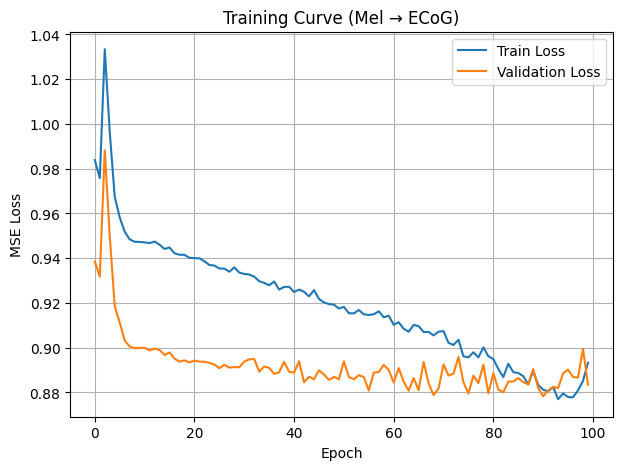

In [24]:
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if MODEL.lower() == 'cnn':
    if USE_WHISPER:
        model = TemporalCNN_deep(WHISPER_FEAT, ecog_train_norm.shape[-1]).to(device)
    else:
        model = TemporalCNN_deep(80, ecog_train_norm.shape[-1]).to(device)
elif MODEL.lower() == 'linear':
    if USE_WHISPER:
        model = Linear_Model(WHISPER_FEAT, ecog_train_norm.shape[-1]).to(device)
    else:
        model = Linear_Model(80, ecog_train_norm.shape[-1]).to(device)

criterion = nn.MSELoss() 
# criterion = nn.L1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
num_epochs = NUM_EPOCHS
# scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
# scheduler = ReduceLROnPlateau(optimizer, "min", patience=25)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for mel, ecog in train_loader:
        mel, ecog = mel.to(device), ecog.to(device)
        optimizer.zero_grad()
        pred = get_model_output(model, mel, whisper=USE_WHISPER)
        # pred = model(mel)
        loss = criterion(pred, ecog)
        loss.backward()
        optimizer.step()
    # ---- VALIDATION ----
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for mel, ecog in val_loader:
            mel, ecog = mel.to(device), ecog.to(device)
            pred = get_model_output(model, mel, whisper=USE_WHISPER)
            loss = criterion(pred, ecog)
            epoch_val_loss += loss.item()
    with torch.no_grad():
        for mel, ecog in train_loader_eval:
            mel, ecog = mel.to(device), ecog.to(device)
            pred = get_model_output(model, mel, whisper=USE_WHISPER)
            loss = criterion(pred, ecog)
            epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)
    epoch_val_loss /= len(val_loader)
    val_losses.append(epoch_val_loss)
    # scheduler.step(epoch_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    model.train()

plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Curve (Mel → ECoG)")
plt.legend()
plt.grid()
plt.show()

if USE_WHISPER:
    CHECKPOINT = f"/home/shahed/SSIP/checkpoints/finkerlab/{MODEL}_with_whisper.pth"
    LOSS_CURVE_SAVE_LOC = f"/home/shahed/SSIP/loss_curves/finkerlab/{MODEL}_with_whisper.pth"
else:
    CHECKPOINT = f"/home/shahed/SSIP/checkpoints/finkerlab/{MODEL}_no_whisper.pth"
    LOSS_CURVE_SAVE_LOC = f"/home/shahed/SSIP/loss_curves/finkerlab/{MODEL}_no_whisper.pth"
    
torch.save(model.state_dict(), CHECKPOINT)
np.save(LOSS_CURVE_SAVE_LOC, np.array(val_losses))


#### **Visualize and Evaluate on test set**

batch idx : 0; random sample idx : 42


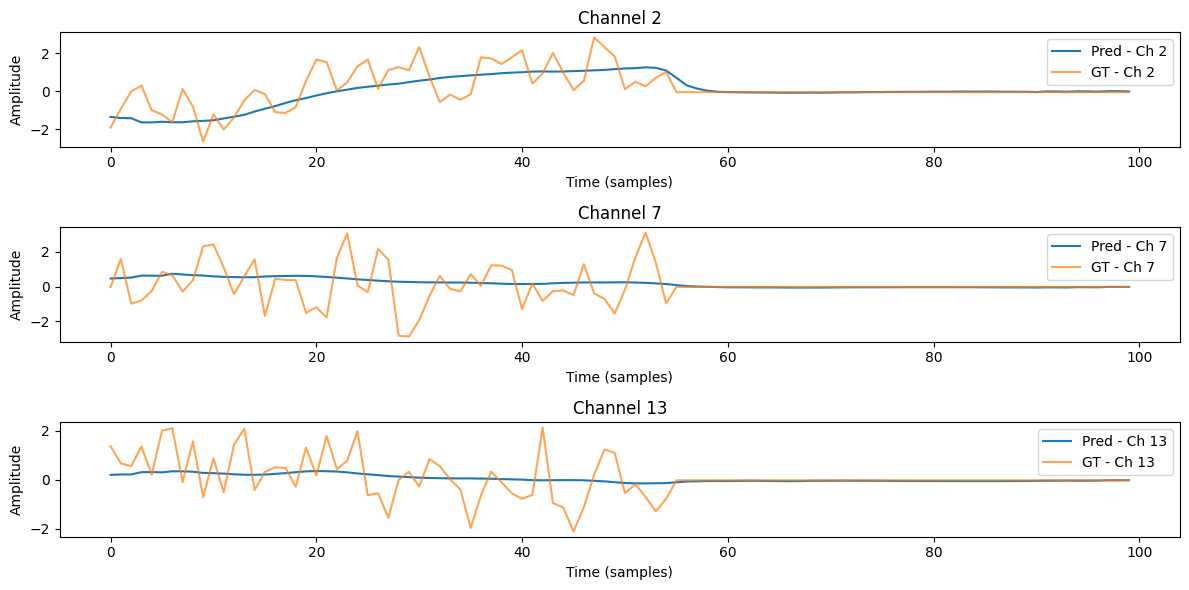

batch idx : 1; random sample idx : 0


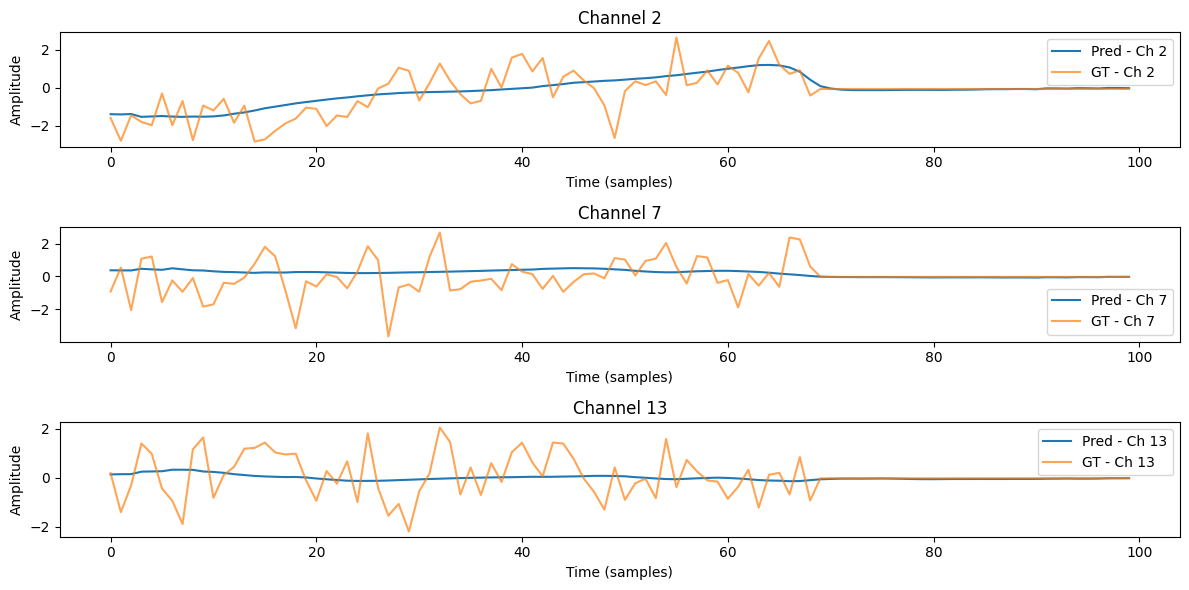


Final test-set mean correlation = 0.2078
Final test-set mse = 0.8835


In [25]:
import matplotlib.pyplot as plt

def visualize_prediction(pred, eeg, sample_idx=1, channels=[0, 1, 2]):
    pred_np = pred[sample_idx].detach().cpu().numpy()   # (300, 254)
    eeg_np = eeg[sample_idx].detach().cpu().numpy()
    plt.figure(figsize=(12, 6))
    for i, ch in enumerate(channels):
        plt.subplot(len(channels), 1, i+1)
        plt.plot(pred_np[:, ch], label=f"Pred - Ch {ch}")
        plt.plot(eeg_np[:, ch], label=f"GT - Ch {ch}", alpha=0.7)
        plt.legend(); plt.xlabel("Time (samples)"); plt.ylabel("Amplitude"); plt.title(f"Channel {ch}")
    plt.tight_layout()
    plt.show()

def pearson_corr_per_channel(pred, gt):
    """
    pred, gt: tensors of shape (B, T, C)
    Returns: (C,) numpy array of Pearson correlations averaged over batch.
    """
    # Ensure shapes
    assert pred.shape == gt.shape
    assert pred.dim() == 3  # (B, T, C)
    B, T, C = pred.shape
    # Move to CPU once
    pred = pred.detach().cpu()
    gt   = gt.detach().cpu()
    # Compute mean over time for each example/channel
    pred_mean = pred.mean(dim=1, keepdim=True)  # (B, 1, C)
    gt_mean   = gt.mean(dim=1, keepdim=True)    # (B, 1, C)
    # Zero-mean
    pred_zm = pred - pred_mean
    gt_zm   = gt - gt_mean
    # Std over time (T dimension)
    pred_std = pred_zm.std(dim=1)  # (B, C)
    gt_std   = gt_zm.std(dim=1)    # (B, C)
    # Covariance over time
    cov = (pred_zm * gt_zm).sum(dim=1) / (T - 1)  # (B, C)
    # Avoid division by tiny stds
    mask = (pred_std < 1e-6) | (gt_std < 1e-6)
    corr = cov / (pred_std * gt_std)  # (B, C)
    corr[mask] = float('nan')
    # Average over batch → final (C,) vector
    corr = corr.mean(dim=0).numpy()
    return corr

batch_idx = 0
model.eval()
all_corrs = []; all_mse_loss = []
for mel, ecog in val_loader:         
    mel = mel.to(device)
    ecog = ecog.to(device)
    pred = get_model_output(model, mel, whisper=USE_WHISPER) ## pred shape is (B, frames, channels)
    corrs = pearson_corr_per_channel(pred, ecog)
    mean_corr = np.nanmean(corrs)
    all_corrs.append(mean_corr)
    mse_loss = nn.MSELoss()(pred, ecog)
    all_mse_loss.append(mse_loss.item())
    # print(f"Mean Pearson correlation = {mean_corr:.4f}")
    # print(f"Top 10% channel correlation = {np.nanmean(np.sort(corrs)[-int(0.1*eeg.shape[-1]):]):.4f}")

    random_sample = random.randint(0, pred.shape[0]-1) 
    print(f'batch idx : {batch_idx}; random sample idx : {random_sample}') 
    visualize_prediction(pred, ecog, sample_idx=random_sample, channels=[2,7,13])
    batch_idx += 1

print("\n======================")
print(f"Final test-set mean correlation = {np.nanmean(all_corrs):.4f}")
print(f"Final test-set mse = {np.nanmean(all_mse_loss):.4f}")
print("======================")

#### **Generate comparison figure (w/ whisper vs. w/o whisper)**

In [26]:
# pretrained_curve = np.load('/home/shahed/SSIP/loss_curves/finkerlab_with_whisper_2conv_05drop.npy')
# pretrained_curve_1 = np.load('/home/shahed/SSIP/loss_curves/finkerlab_with_whisper_1conv_05drop.npy')
# no_pretrained_curve = np.load('/home/shahed/SSIP/loss_curves/finkerlab_no_whisper.npy')

# plt.figure(figsize=(8,4))

# plt.plot(pretrained_curve, label="w/ Whisper, 2C1L", linewidth=2)
# plt.plot(pretrained_curve_1, label="w/ Whisper, 1C1L", linewidth=2)
# plt.plot(no_pretrained_curve, label="w/o Whisper, 2C1L", linewidth=2, linestyle="--")

# plt.title("Validation Loss Curve Comparison", fontsize=14)
# plt.xlabel("Epochs", fontsize=10)
# plt.ylabel("MSE loss", fontsize=10)

# plt.grid(True, linestyle="--", alpha=0.5)
# plt.legend(fontsize=10)

# plt.tight_layout()
# plt.savefig(f'/home/shahed/SSIP/loss_curves/comparison_finkerlab.png')
